<h1><center>IAGA Summer School 2019</center></h1>

<h1><center>Spherical hamonics and the IGRF</center></h1>

In [1]:
# Import notebook dependencies

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')
from src import sha_lib as sha, mag_lib as mag

IGRF12_FILE = os.path.abspath('../data/external/igrf12coeffs.txt')
LAND_FILE = os.path.abspath('../data/external/land_5deg.csv')

## 1. The International Geomagnetic Reference Field (IGRF)
The latest version of the IGRF is IGRF12 which consists of a main-field model every five years from 1900.0 to 2015.0 and a secular variation model for 2015-2020. The main field models have spherical harmonic degree (n) and order (m) 10 up to 1995 and n=m=13 from 2000 onwards. The secular variation model has n=m=8. (In this notebook we will work with the IGRF for 2015.0 only but it is simple to interpolate models for dates between 1900 and 2015, and to use the secular variation model to extrapolate beyond 2015.)

The coefficients are first loaded into a pandas dataframe:

In [2]:
igrf12 = pd.read_csv(IGRF12_FILE, delim_whitespace=True,  header=3)
igrf12.head()  # Check the values have loaded correctly

,g/h,n,m,1900.0,1905.0,1910.0,1915.0,1920.0,1925.0,1930.0,...,1975.0,1980.0,1985.0,1990.0,1995.0,2000.0,2005.0,2010.0,2015.0,2015-20
0,g,1,0,-31543,-31464,-31354,-31212,-31060,-30926,-30805,...,-30100,-29992,-29873,-29775,-29692,-29619.4,-29554.63,-29496.57,-29442.0,10.3
1,g,1,1,-2298,-2298,-2297,-2306,-2317,-2318,-2316,...,-2013,-1956,-1905,-1848,-1784,-1728.2,-1669.05,-1586.42,-1501.0,18.1
2,h,1,1,5922,5909,5898,5875,5845,5817,5808,...,5675,5604,5500,5406,5306,5186.1,5077.99,4944.26,4797.1,-26.6
3,g,2,0,-677,-728,-769,-802,-839,-893,-951,...,-1902,-1997,-2072,-2131,-2200,-2267.7,-2337.24,-2396.06,-2445.1,-8.7
4,g,2,1,2905,2928,2948,2956,2959,2969,2980,...,3010,3027,3044,3059,3070,3068.4,3047.69,3026.34,3012.9,-3.3


## 2. Spherical harmonics and representing the geomagnetic field

The north (X), east (Y) and vertical (Z) (downwards) components of the geomagnetic field at colatitude $\theta$, longitude $\phi$ and radial distance $r$ (in geocentric coordinates with reference radius $a$=6371.2 km for the IGRF) are calculated as follows:

$$\begin{align}
&X= \sum_{n=1}^N\left(\frac{a}{r}\right)^{n+2}\left[ g_n^oX_n^o+\sum_{m=1}^N\left( g_n^m\cos m\phi+h_n^m\sin m\phi \right)X_n^m\right]\\[6pt]
&Y= \sum_{n=1}^N\left(\frac{a}{r}\right)^{n+2} \sum_{m=1}^N \left(g_n^m\sin m\phi-h_n^m\cos m\phi \right)Y_n^m \\[6pt]
&Z= \sum_{n=1}^N\left(\frac{a}{r}\right)^{n+2} \left[g_n^oZ_n^o+\sum_{m=1}^N\left( g_n^m\cos m\phi+h_n^m\sin m\phi \right)Z_n^m\right]\\[6pt]
\text{with}&\\[6pt]
&X_n^m=\frac{dP_n^n}{d\theta}\\[6pt]
&Y_n^m=\frac{m}{\sin \theta}P_n^m \kern{10ex} \text{(Except at the poles where $Y_n^m=X_n^m\cos \theta$.)}\\[6pt]
&Z_n^m=-(n+1)P_n^m
\end{align}$$


where the ($g_n^m, h_n^m$) are the Gauss coefficients as listed in the IGRF Table.

The Associated Legendre polynomials of degree $l$ and order $m$ are defined, in Schmidt semi-normalised form by,

$$P^l_m= \frac{1}{2^1l!}\left[ \frac{(2-\delta_{om})(l-m)!\left(1-x^2\right)^m}{n+m)!} \right]^{1/2}\frac{d^{l+m}}{dx^{l+m}}\left(1-x^2\right)^{l}$$


and the $X_n^m$, $Y_n^m$ and $Z_n^n$ may be calculated using the following recurrence relations (e.g. Malin and Barraclough, 1980),

$$\begin{align}
P_n^n&=\left(1-\frac{1}{2n}\right)^{1/2}\sin \theta \thinspace P_{n-1}^{n-1} \\[6pt]
P_n^m&=\left[\left(2n-1\right) \cos \theta \thinspace P_{n-1}^m-\left[ \left(n-1\right)^2-m^2\right]^{1/2}P_{n-2}^m\right]\left(n^2-m^2\right)^{-1/2}\\[6pt]
X_n^n&=\left(1-\frac{1}{2n}\right)^{1/2}\left( \sin \theta \thinspace X_{n-1}^{n-1}+ \cos \theta \thinspace P_{n-1}^{n-1} \right)\\[6pt]
X_n^m&=\left[\left(2n-1\right) \cos \theta \thinspace X_{n-1}^m- \sin \theta \thinspace P_{n-1}^m\right] - \left[ \left(n-1\right)^2-m^2\right]^{1/2}X_{n-2}^m\left(n^2-m^2\right)^{-1/2}
\end{align}$$

### Plotting functions P(n,m) and X(n,m)
The $P_n^m(\theta)$ and $X_n^m(\theta)$ are building blocks for computing geomagnetic field models given a spherical harmonic model. It's instructive to visualise these functions and below you can experiment by setting different values of spherical harmonic degree ($n$) and order ($m \le n$). Note how the choice of $n$ and $m$ affects the number of zeroes of the functions. 

(The functions are plotted on a semi-circle representing the surface of the Earth, with the inner core added for cosmetic purposes only! Again, for cosmetic purposes the functions are scaled to fit within +/-10% of the Earth's surface.)

**Set the degree and order for the plot**

In [3]:
degree = 11
order  = 1

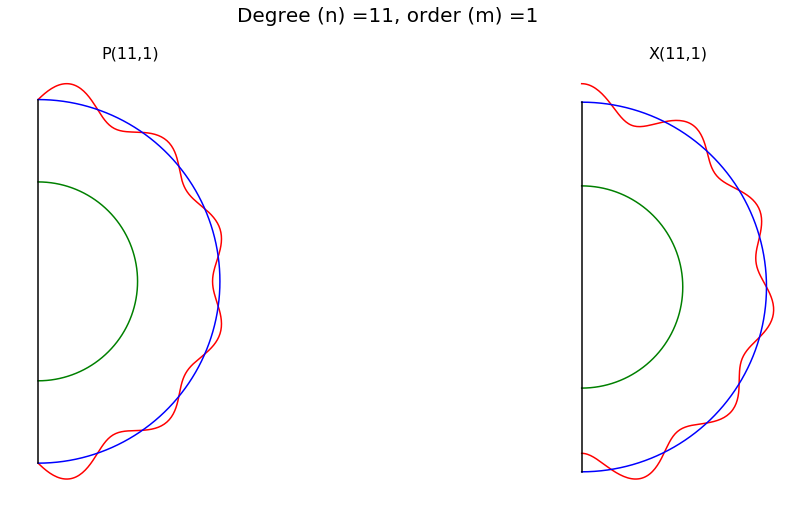

In [4]:
colat   = np.linspace(0,180,361)
pnmvals = np.zeros(len(colat))
xnmvals = np.zeros(len(colat))
idx     = sha.pnmindex(degree,order)

for i, cl in enumerate(colat):
    p,x = sha.pxyznm_calc(degree, cl)[0:2]
    pnmvals[i] = p[idx]
    xnmvals[i] = x[idx]
    
theta   = np.deg2rad(colat)
ct      = np.cos(theta)
st      = np.sin(theta)

# Numbers mimicking the Earth's surface and outer core radii
e_rad   = 6.371
c_rad   = 3.485

# Scale values to fit within 10% of "Earth's surface". Firstly the P(n,m),
shell   = 0.1*e_rad
pmax    = np.abs(pnmvals).max()
pnmvals = pnmvals*shell/pmax + e_rad
xp      = pnmvals*st
yp      = pnmvals*ct

# now the X(n,m)
xmax    = np.abs(xnmvals).max()
xnmvals = xnmvals*shell/xmax + e_rad # + shell
xx      = xnmvals*st
yx      = xnmvals*ct

# Values to draw the Earth's and outer core surfaces as semi-circles
e_xvals = e_rad*st
e_yvals = e_rad*ct
c_xvals = e_xvals*c_rad/e_rad
c_yvals = e_yvals*c_rad/e_rad

# Plot the P(n,m) and X(n,m)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle('Degree (n) ='+str(degree)+', order (m) ='+str(order), fontsize=20)

axes[0].set_aspect('equal')
axes[0].set_axis_off()
axes[0].plot(xp,yp, color='red')
axes[0].plot(e_xvals,e_yvals, color='blue')
axes[0].plot(c_xvals,c_yvals, color='green')
axes[0].plot((0,0),(-e_rad,e_rad), color='black')
axes[0].set_title('P('+ str(degree)+',' + str(order)+')', fontsize=16)

axes[1].set_aspect('equal')
axes[1].set_axis_off()
axes[1].plot(xx,yx, color='red')
axes[1].plot(e_xvals,e_yvals, color='blue')
axes[1].plot(c_xvals,c_yvals, color='green')
axes[1].plot((0,0),(-e_rad,e_rad), color='black')
axes[1].set_title('X('+ str(degree)+',' + str(order)+')', fontsize=16);

## 3. Calculating geomagnetic field values using the IGRF
The following code is a simple implementation of a function to allow computation of geomagnetic field values at a point defined by its colatitude, longitude and altitude, using a spherical harmonic model of maximum degree _nmax_ supplied as an array _gh_. The parameter _coord_ is a string specifying whether the input position is in geocentric coordinates (when _altitude_ should be the geocentric distance in km) or geodetic coordinates (when altitude is distance above mean sea level in km). <br><br>

In [5]:
def shm_calculator(gh, nmax, altitude, colat, long, coord):
    RREF     = 6371.2  # The reference radius assumed by the IGRF
    degree   = nmax
    phi      = long
    if (coord == 'Geodetic'):
        # Geodetic to geocentric conversion using the WGS84 spheroid
        rad, theta, sd, cd = sha.gd2gc(altitude, colat)
    else:
        rad   = altitude
        theta = colat
    # Function 'rad_powers' to create an array with values of (a/r)^(n+2) for n = 0,1, 2 ..., degree
    rpow = sha.rad_powers(degree, RREF, rad)
    # Function 'csmphi' to create arrays with cos(m*phi), sin(m*phi) for m = 0, 1, 2 ..., degree
    cmphi, smphi = sha.csmphi(degree,phi)
    # Function 'gh_phi_rad' to create arrays with terms such as [g(3,2)*cos(2*phi) + h(3,2)*sin(2*phi)]*(a/r)**5 
    ghxz, ghy = sha.gh_phi_rad(gh, degree, cmphi, smphi, rpow)
    # Function 'pnm_calc' to calculate arrays of the Associated Legendre Polynomials for n (&m) = 0,1, 2 ..., degree
    pnm, xnm, ynm, znm = sha.pxyznm_calc(degree, theta)
    # Geomagnetic field components are calculated as a dot product
    X =  np.dot(ghxz, xnm)
    Y =  np.dot(ghy,  ynm)
    Z = -np.dot(ghxz, znm)
    # Convert back to geodetic (X, Y, Z) if required
    if (coord == 'Geodetic'):
        t = X
        X = X*cd + Z*sd
        Z = Z*cd - t*sd
    return((X, Y, Z))

The code below will allow you caculate the IGRF estimate for the 

In [6]:
gh2015 = np.append(0., igrf12['2015.0']) # Add a zero monopole term corresponding to g(0,0)

location = 'Erehwon'
ctype    = 'Geodetic'  # coordinate type
NMAX     = 13          # maxiimum spherical harmonic degree of the model
altitude = 0           # in km above the spheroid if ctype = 'Geodetic', radial distance if ctype = 'Geocentric'
colat    = 90-56       # NB colatitude, not latitude
long     = -3          # longitude
bxyz     = shm_calculator(gh2015, NMAX, altitude, colat, long, ctype)
dec, hoz ,inc , eff = mag.xyz2dhif(bxyz[0], bxyz[1], bxyz[2])

print('\nGeomagnetic field values at: ', location, '\n')
print('Declination (D):', '{0:.1f}'.format(dec), 'degrees')
print('Inclination (I):', '{0:.1f}'.format(inc), 'degrees')
print('Horizontal intensity (H):', '{0:.1f}'.format(hoz), 'nT')
print('Total intensity (F)     :', '{0:.1f}'.format(eff), 'nT')
print('North component (X)     :', '{0:.1f}'.format(bxyz[0]), 'nT')
print('East component (Y)      :', '{0:.1f}'.format(bxyz[1]), 'nT')
print('Vertical component (Z)  :', '{0:.1f}'.format(bxyz[2]), 'nT')



Geomagnetic field values at:  Erehwon 

Declination (D): -2.7 degrees
Inclination (I): -70.2 degrees
Horizontal intensity (H): 16898.3 nT
Total intensity (F)     : 49866.3 nT
North component (X)     : 16879.5 nT
East component (Y)      : -797.9 nT
Vertical component (Z)  : -46915.9 nT


## 4. A more tangible example of modelling using spherical harmonics

First, there's a data file with some spatial data to plot (courtesy of John Stevenson).

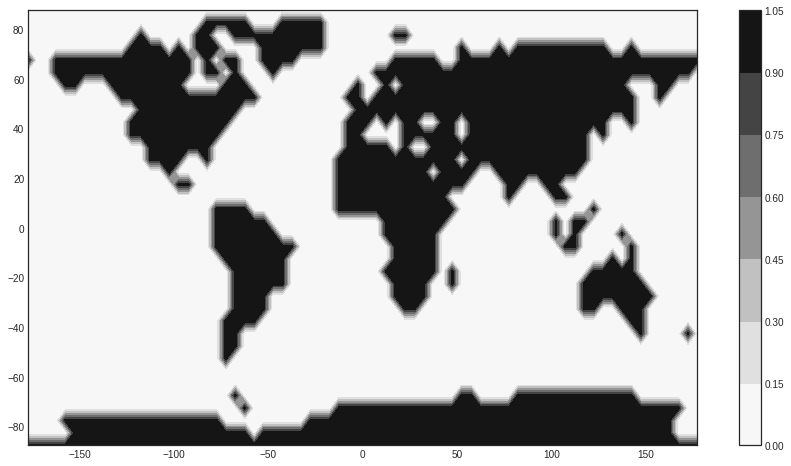

In [7]:
plt.style.use('seaborn-white')

lsdata = np.genfromtxt(LAND_FILE, delimiter=',')
x = lsdata[:,0].reshape(36, 72)
y = lsdata[:,1].reshape(36,72)
z = lsdata[:,2].reshape(36,72)
plt.figure(figsize=(15, 8))
plt.contourf(x,y,z)
plt.colorbar();

The data file consists of values (1=land, 0=water) on a 5-degree grid. Now take these data as the input to a global spherical harmonic analysis and calculate a spherical harmonic model.

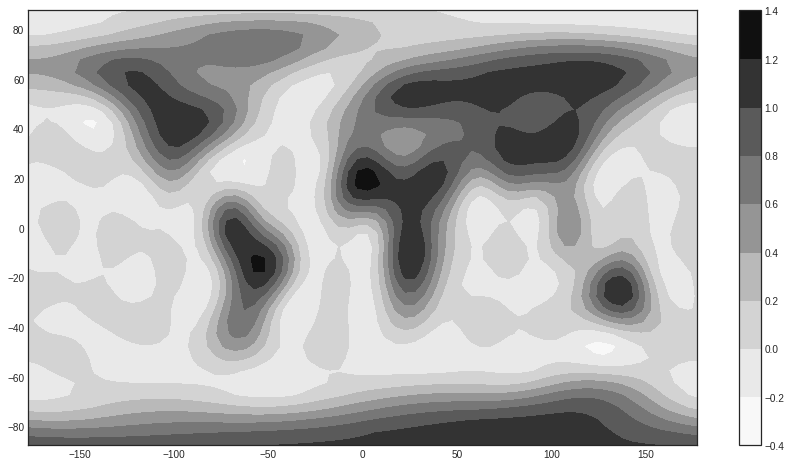

In [8]:
# Firstly compute a spherical harmonic model of degree and order nmax
#  using the input data as plotted above
nmax = 12
npar = (nmax+1)*(nmax+1)
ndat = len(lsdata)
lhs  = np.zeros(npar*ndat).reshape(ndat,npar)

rhs  = np.zeros(ndat)
line = np.zeros(npar)
ic   = -1
for i in range(ndat):
    th  = 90 - lsdata[i][1]
    ph  = lsdata[i][0]
    rhs[i] = lsdata[i][2]
    cmphi, smphi = sha.csmphi(nmax,ph)
    pnm = sha.pnm_calc(nmax, th)
    for n in range(nmax+1):
        igx = sha.gnmindex(n,0)
        ipx = sha.pnmindex(n,0)
        line[igx] = pnm[ipx]
        for m in range(1,n+1):
            igx = sha.gnmindex(n,m)
            ihx = sha.hnmindex(n,m)
            ipx = sha.pnmindex(n,m)
            line[igx] = pnm[ipx]*cmphi[m]
            line[ihx] = pnm[ipx]*smphi[m]
    lhs[i,:] = line

shmod  = np.linalg.lstsq(lhs, rhs.reshape(len(lsdata),1), rcond=None)

# Read the model coefficients
shcofs = shmod[0]

# Now use the model to synthesise values on a 5 degree grid in latitude and longitude
newdata =np.zeros(72*36*3).reshape(2592,3)
ic = 0
for ilat in range(36):
    delta = 5*ilat+2.5
    lat = 90 - delta
    for iclt in range(72):
        corr  = 5*iclt+2.5
        long  = -180+corr
        colat = 90-lat
        cmphi, smphi = sha.csmphi(nmax,long)
        vals  = np.dot(sha.gh_phi(shcofs, nmax, cmphi, smphi), sha.pnm_calc(nmax, colat))
        newdata[ic,0]=long
        newdata[ic,1]=lat
        newdata[ic,2]=vals
        ic += 1

# Plot the results
x = newdata[:,0].reshape(36, 72)
y = newdata[:,1].reshape(36,72)
z = newdata[:,2].reshape(36,72)
levels = [-1.5, -0.75, 0, 0.25, 0.5, 0.75, 2.]
plt.figure(figsize=(15, 8))
plt.contourf(x,y,z)
plt.colorbar()
plt.show()